In [2]:
import tensorflow.keras.backend as K
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from modules.preprocessing import cleanup
from tensorflow.keras.layers import Dense, Input,Layer
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from typing import List
from collections import defaultdict, Counter

In [2]:
import os
import sys
import json
import requests
from datetime import datetime


def download(lang: str, category: str, widget: str):
    assert type(lang) == str, "'lang' tiene que ser string. Consulte https://www.ree.es/es/apidatos"
    assert type(category) == str, "'category' tiene que ser string. Consulte https://www.ree.es/es/apidatos"
    assert type(widget) == str, "'widget' tiene que ser string. Consulte https://www.ree.es/es/apidatos"
    FMT = '%Y-%m-%dT%H:%M'
    BASE_URL = "http://apidatos.ree.es/"
    time_trunc = "hour"
    url = BASE_URL + f"{lang}/datos/{category}/{widget}?"


    def get_month_data(start_date: datetime, end_date: datetime, year: int, month: int):
        name = os.path.join(".","datasets",category,f"datos-{category}-{month}-{year}.json")
        if not os.path.isfile(name):
            if not os.path.isdir(os.path.dirname(name)):
                os.mkdir(os.path.dirname(name))  
            _url = url + f"start_date={start_date.strftime(FMT)}&end_date={end_date.strftime(FMT)}&time_trunc={time_trunc}"
            print(f"Haciendo solicitud a {_url}")
            r = requests.get(_url)
            data = r.json()
            if not 'errors' in data:
                print("Descargando de " + _url)
                with open(name, "w") as f:
                    json.dump(data, f)
            else:
                print("Error en la solicitud a " + _url)

    for year in (2017, 2018, 2019):
        for month in range(1,13):
            start_date = datetime(year,month,1)
            if month == 2:
                end_date = datetime(year, month,28,23,50)
            elif month in (1,3,5,7,8,10,12):
                end_date = datetime(year, month,31,23,50)
            else:
                end_date = datetime(year, month,30,23,50)
            get_month_data(start_date, end_date, year, month)


In [3]:
download("es", "demanda", "demanda-tiempo-real")

In [3]:
file = "datasets/demanda/datos-demanda-{m}-{y}.json"
data = pd.DataFrame()
dates = []
for year in (2017,2018,2019):
    for m in range(1,13):
        values = cleanup(file.format(m=m, y=year), 'minute')
        for d in range(1,len(values)+1):
            dates.append(datetime(year, m, d).strftime("%A, %d - %b - %y"))
        data = data.append(values)
dates = pd.Series(dates)

In [4]:
data = scale(data)

In [5]:
n_clusters = 20
models = [KMeans(n_clusters=i) for i in range(2,n_clusters+1)]
scores = [model.fit(data).score(data) for model in models]
sillhouette_scores = [silhouette_score(data, model.predict(data)) for model in models]


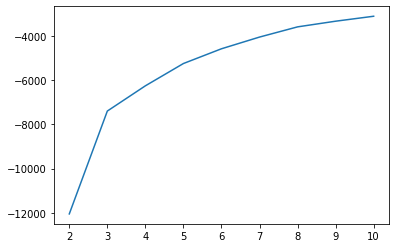

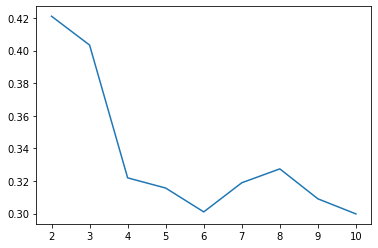

In [6]:
plt.show(plt.plot(range(2,11), scores[:9]))
plt.show(plt.plot(range(2,11), sillhouette_scores[:9]))

In [7]:
model = models[6]

In [8]:
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
silhouette_score(data, model.predict(data))

0.32634391325939627

In [10]:
clustering_demanda = []
for c,d in zip(model.predict(data), dates):
    clustering_demanda.append((d,c))

In [11]:
clustering_demanda

[('Sunday, 01 - Jan - 17', 0),
 ('Monday, 02 - Jan - 17', 2),
 ('Tuesday, 03 - Jan - 17', 1),
 ('Wednesday, 04 - Jan - 17', 1),
 ('Thursday, 05 - Jan - 17', 6),
 ('Friday, 06 - Jan - 17', 4),
 ('Saturday, 07 - Jan - 17', 2),
 ('Sunday, 08 - Jan - 17', 7),
 ('Monday, 09 - Jan - 17', 1),
 ('Tuesday, 10 - Jan - 17', 3),
 ('Wednesday, 11 - Jan - 17', 3),
 ('Thursday, 12 - Jan - 17', 3),
 ('Friday, 13 - Jan - 17', 1),
 ('Saturday, 14 - Jan - 17', 7),
 ('Sunday, 15 - Jan - 17', 7),
 ('Monday, 16 - Jan - 17', 1),
 ('Tuesday, 17 - Jan - 17', 3),
 ('Wednesday, 18 - Jan - 17', 3),
 ('Thursday, 19 - Jan - 17', 3),
 ('Friday, 20 - Jan - 17', 3),
 ('Saturday, 21 - Jan - 17', 5),
 ('Sunday, 22 - Jan - 17', 7),
 ('Monday, 23 - Jan - 17', 3),
 ('Tuesday, 24 - Jan - 17', 3),
 ('Wednesday, 25 - Jan - 17', 3),
 ('Thursday, 26 - Jan - 17', 3),
 ('Friday, 27 - Jan - 17', 3),
 ('Saturday, 28 - Jan - 17', 7),
 ('Sunday, 29 - Jan - 17', 7),
 ('Monday, 30 - Jan - 17', 1),
 ('Tuesday, 31 - Jan - 17', 1),
 ('Wed

In [12]:
list(filter(lambda x: x[1] == 1, clustering_demanda))

[('Tuesday, 03 - Jan - 17', 1),
 ('Wednesday, 04 - Jan - 17', 1),
 ('Monday, 09 - Jan - 17', 1),
 ('Friday, 13 - Jan - 17', 1),
 ('Monday, 16 - Jan - 17', 1),
 ('Monday, 30 - Jan - 17', 1),
 ('Tuesday, 31 - Jan - 17', 1),
 ('Wednesday, 01 - Feb - 17', 1),
 ('Thursday, 02 - Feb - 17', 1),
 ('Friday, 03 - Feb - 17', 1),
 ('Monday, 06 - Feb - 17', 1),
 ('Tuesday, 07 - Feb - 17', 1),
 ('Wednesday, 08 - Feb - 17', 1),
 ('Thursday, 09 - Feb - 17', 1),
 ('Monday, 13 - Feb - 17', 1),
 ('Tuesday, 14 - Feb - 17', 1),
 ('Wednesday, 15 - Feb - 17', 1),
 ('Thursday, 16 - Feb - 17', 1),
 ('Friday, 17 - Feb - 17', 1),
 ('Monday, 20 - Feb - 17', 1),
 ('Tuesday, 21 - Feb - 17', 1),
 ('Wednesday, 22 - Feb - 17', 1),
 ('Thursday, 23 - Feb - 17', 1),
 ('Friday, 24 - Feb - 17', 1),
 ('Wednesday, 01 - Mar - 17', 1),
 ('Thursday, 02 - Mar - 17', 1),
 ('Friday, 03 - Mar - 17', 1),
 ('Thursday, 23 - Mar - 17', 1),
 ('Friday, 24 - Mar - 17', 1),
 ('Monday, 12 - Jun - 17', 1),
 ('Monday, 10 - Jul - 17', 1),
 ('M

In [13]:
file = "datasets/mercados/datos-mercados-{m}-{y}.json"
data = pd.DataFrame()
for year in (2017,2018,2019):
    for m in range(1,13):
        values = cleanup(file.format(m=m, y=year), 'hour')
        data = data.append(values)


In [32]:
data = scale(data)

In [33]:
n_clusters = 20
models = [KMeans(n_clusters=i) for i in range(2,n_clusters+1)]
scores = [model.fit(data).score(data) for model in models]
sillhouette_scores = [silhouette_score(data, model.predict(data)) for model in models]

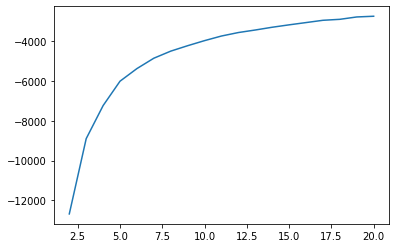

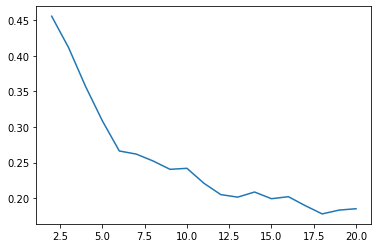

In [34]:
plt.show(plt.plot(range(2,21), scores))
plt.show(plt.plot(range(2,n_clusters+1), sillhouette_scores))

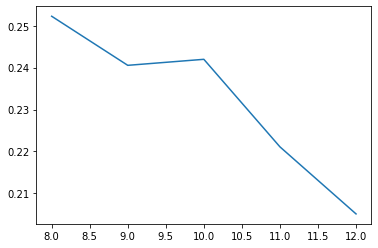

In [35]:
plt.show(plt.plot(range(8,13), sillhouette_scores[6:11]))

In [36]:
sillhouette_scores

[0.4553147534776003,
 0.4112775803169828,
 0.35706758021230023,
 0.3085227252567953,
 0.26630360532586306,
 0.26194453414393454,
 0.252253814716281,
 0.24054486555218807,
 0.24198040623663833,
 0.22110000695473436,
 0.2051010507497462,
 0.20153659413060776,
 0.20871533412978324,
 0.19932295590591392,
 0.20216478833902557,
 0.1895421642382816,
 0.178001043770371,
 0.18335540504857553,
 0.18529053263417986]

In [116]:
sillhouette_scores.index(0.2438380581456667)

8

In [37]:
model = models[8]
clustering_mercado = []
for c,d in zip(model.predict(data), dates):
    clustering_mercado.append((d,c))

In [38]:
clustering = defaultdict(int)
for i in range(len(dates)):
    clustering[(clustering_demanda[i][1], clustering_mercado[i][1])] +=1
    

In [118]:
clustering_mercado

[('Sunday, 01 - Jan - 17', 9),
 ('Monday, 02 - Jan - 17', 9),
 ('Tuesday, 03 - Jan - 17', 1),
 ('Wednesday, 04 - Jan - 17', 1),
 ('Thursday, 05 - Jan - 17', 1),
 ('Friday, 06 - Jan - 17', 1),
 ('Saturday, 07 - Jan - 17', 1),
 ('Sunday, 08 - Jan - 17', 9),
 ('Monday, 09 - Jan - 17', 1),
 ('Tuesday, 10 - Jan - 17', 1),
 ('Wednesday, 11 - Jan - 17', 1),
 ('Thursday, 12 - Jan - 17', 1),
 ('Friday, 13 - Jan - 17', 1),
 ('Saturday, 14 - Jan - 17', 1),
 ('Sunday, 15 - Jan - 17', 1),
 ('Monday, 16 - Jan - 17', 1),
 ('Tuesday, 17 - Jan - 17', 1),
 ('Wednesday, 18 - Jan - 17', 4),
 ('Thursday, 19 - Jan - 17', 4),
 ('Friday, 20 - Jan - 17', 4),
 ('Saturday, 21 - Jan - 17', 4),
 ('Sunday, 22 - Jan - 17', 4),
 ('Monday, 23 - Jan - 17', 4),
 ('Tuesday, 24 - Jan - 17', 4),
 ('Wednesday, 25 - Jan - 17', 4),
 ('Thursday, 26 - Jan - 17', 4),
 ('Friday, 27 - Jan - 17', 4),
 ('Saturday, 28 - Jan - 17', 1),
 ('Sunday, 29 - Jan - 17', 1),
 ('Monday, 30 - Jan - 17', 1),
 ('Tuesday, 31 - Jan - 17', 1),
 ('Wed

In [24]:
clusters = pd.DataFrame()
for pair in clustering:
    for _ in range(clustering[pair]):
        clusters = clusters.append(pd.Series(pair), ignore_index=True)
    

In [27]:
clusters.to_csv("clusters.csv", header=["demanda","mercado"], index=False)

In [70]:
clustering_etiquetado_demanda = defaultdict(list)
for cluster in clustering_demanda:
    date = datetime.strptime(cluster[0], "%A, %d - %b - %y")
    year = date.year
    if date < datetime(year, 3, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["invierno festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["invierno lectivo"].append(cluster[1])
    elif date < datetime(year, 6, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["primavera festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["primavera lectivo"].append(cluster[1])
    elif date < datetime(year, 9, 22):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["verano festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["verano lectivo"].append(cluster[1])
    else:
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["otoño festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["otoño lectivo"].append(cluster[1])

In [71]:
for temporada in clustering_etiquetado_demanda:
    clustering_etiquetado_demanda[temporada] = Counter(clustering_etiquetado_demanda[temporada])

In [5]:
festivos = {2017:[datetime(2017,1,1),
                  datetime(2017,1,6),
                  datetime(2017,2,2),
                  datetime(2017,2,26),
                  datetime(2017,4,10),
                  datetime(2017,4,11),
                  datetime(2017,4,12),
                  datetime(2017,4,13),
                  datetime(2017,4,14),
                  datetime(2017,4,15),
                  datetime(2017,4,16),
                  datetime(2017,5,1),
                  datetime(2017,10,12),
                  datetime(2017,11,1),
                  datetime(2017,12,6),
                  datetime(2017,12,7),
                  datetime(2017,12,8),
                  datetime(2017,12,24),
                  datetime(2017,12,25),
                  datetime(2017,12,31)],
            2018:[datetime(2018,1,1),
                  datetime(2018,1,6),
                  datetime(2018,2,2),
                  datetime(2018,2,11),
                  datetime(2018,3,28),
                  datetime(2018,3,27),
                  datetime(2018,3,28),
                  datetime(2018,3,29),
                  datetime(2018,3,30),
                  datetime(2018,3,31),
                  datetime(2018,4,1),
                  datetime(2018,5,1),
                  datetime(2018,10,12),
                  datetime(2018,11,1),
                  datetime(2018,12,6),
                  datetime(2018,12,7),
                  datetime(2018,12,8),
                  datetime(2018,12,24),
                  datetime(2018,12,25),
                  datetime(2018,12,31)],
            2019:[datetime(2019,1,1),
                  datetime(2019,1,6),
                  datetime(2019,2,2),
                  datetime(2019,2,11),
                  datetime(2019,3,3),
                  datetime(2019,4,15),
                  datetime(2019,4,16),
                  datetime(2019,4,17),
                  datetime(2019,4,18),
                  datetime(2019,3,19),
                  datetime(2019,4,20),
                  datetime(2019,4,21),
                  datetime(2019,5,1),
                  datetime(2019,10,12),
                  datetime(2019,11,1),
                  datetime(2019,12,6),
                  datetime(2019,12,7),
                  datetime(2019,12,8),
                  datetime(2019,12,24),
                  datetime(2019,12,25),
                  datetime(2019,12,31)]}

In [106]:
for temporada in clustering_etiquetado_demanda:
    clustering_etiquetado_demanda[temporada] = Counter(clustering_etiquetado_demanda[temporada])

In [107]:
s = 0
for x in sorted(clustering_etiquetado_demanda):
    s += sum(clustering_etiquetado_demanda[x][i] for i in range(8))
    print(x, [ f"{i}:{clustering_etiquetado_demanda[x][i]}" for i in range(8)], "\n")
    
print(s)

invierno festivo ['0:0', '1:6', '2:0', '3:21', '4:6', '5:33', '6:1', '7:0'] 

invierno lectivo ['0:23', '1:2', '2:68', '3:1', '4:1', '5:0', '6:7', '7:65'] 

otoño festivo ['0:0', '1:29', '2:0', '3:42', '4:1', '5:17', '6:0', '7:0'] 

otoño lectivo ['0:66', '1:7', '2:20', '3:6', '4:2', '5:3', '6:39', '7:71'] 

primavera festivo ['0:0', '1:34', '2:0', '3:36', '4:1', '5:7', '6:0', '7:0'] 

primavera lectivo ['0:124', '1:9', '2:9', '3:3', '4:2', '5:0', '6:36', '7:15'] 

verano festivo ['0:0', '1:9', '2:0', '3:33', '4:5', '5:32', '6:0', '7:0'] 

verano lectivo ['0:46', '1:0', '2:23', '3:3', '4:102', '5:0', '6:7', '7:22'] 

1095


In [108]:
clustering_etiquetado_demanda

defaultdict(list,
            {'invierno festivo': Counter({1: 6, 6: 1, 5: 33, 4: 6, 3: 21}),
             'invierno lectivo': Counter({6: 7,
                      7: 65,
                      0: 23,
                      3: 1,
                      2: 68,
                      1: 2,
                      4: 1}),
             'primavera lectivo': Counter({6: 36,
                      0: 124,
                      7: 15,
                      1: 9,
                      4: 2,
                      2: 9,
                      3: 3}),
             'primavera festivo': Counter({5: 7, 3: 36, 1: 34, 4: 1}),
             'verano lectivo': Counter({2: 23,
                      4: 102,
                      0: 46,
                      7: 22,
                      6: 7,
                      3: 3}),
             'verano festivo': Counter({5: 32, 3: 33, 1: 9, 4: 5}),
             'otoño lectivo': Counter({0: 66,
                      6: 39,
                      3: 6,
                      1: 7,

In [120]:
clustering_etiquetado_mercado = defaultdict(list)
for cluster in clustering_mercado:
    date = datetime.strptime(cluster[0], "%A, %d - %b - %y")
    year = date.year
    if date < datetime(year, 3, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_mercado["invierno festivo"].append(cluster[1])
        else:
            clustering_etiquetado_mercado["invierno lectivo"].append(cluster[1])
    elif date < datetime(year, 6, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_mercado["primavera festivo"].append(cluster[1])
        else:
            clustering_etiquetado_mercado["primavera lectivo"].append(cluster[1])
    elif date < datetime(year, 9, 22):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_mercado["verano festivo"].append(cluster[1])
        else:
            clustering_etiquetado_mercado["verano lectivo"].append(cluster[1])
    else:
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_mercado["otoño festivo"].append(cluster[1])
        else:
            clustering_etiquetado_mercado["otoño lectivo"].append(cluster[1])

In [122]:
for temporada in clustering_etiquetado_mercado:
    clustering_etiquetado_mercado[temporada] = Counter(clustering_etiquetado_mercado[temporada])

In [124]:
s = 0
for x in sorted(clustering_etiquetado_mercado):
    s += sum(clustering_etiquetado_mercado[x][i] for i in range(10))
    print(x, [ f"{i}:{clustering_etiquetado_mercado[x][i]}" for i in range(10)], "\n")
    
print(s)

invierno festivo ['0:15', '1:5', '2:4', '3:9', '4:2', '5:3', '6:1', '7:5', '8:10', '9:13'] 

invierno lectivo ['0:25', '1:21', '2:1', '3:50', '4:8', '5:7', '6:1', '7:5', '8:19', '9:30'] 

otoño festivo ['0:6', '1:6', '2:8', '3:21', '4:0', '5:1', '6:4', '7:13', '8:6', '9:24'] 

otoño lectivo ['0:10', '1:38', '2:8', '3:32', '4:0', '5:3', '6:5', '7:27', '8:28', '9:63'] 

primavera festivo ['0:19', '1:0', '2:7', '3:0', '4:0', '5:0', '6:2', '7:15', '8:29', '9:6'] 

primavera lectivo ['0:65', '1:0', '2:5', '3:5', '4:0', '5:0', '6:1', '7:34', '8:73', '9:15'] 

verano festivo ['0:4', '1:4', '2:4', '3:2', '4:0', '5:0', '6:0', '7:18', '8:28', '9:19'] 

verano lectivo ['0:24', '1:24', '2:7', '3:1', '4:0', '5:0', '6:0', '7:22', '8:82', '9:43'] 

1095


In [128]:
for x in sorted(clustering_etiquetado_mercado):
    print(sum(clustering_etiquetado_mercado[x][i] for i in range(10)))

67
167
89
214
78
198
79
203


<img src="./data/precio - 1.png">

In [47]:
for pair in sorted(clustering):
    
    print( pair, clustering[pair])

(0, 0) 37
(0, 1) 31
(0, 2) 43
(0, 3) 2
(0, 4) 1
(0, 5) 2
(0, 6) 16
(0, 7) 32
(0, 8) 9
(0, 9) 6
(1, 0) 6
(1, 1) 17
(1, 2) 9
(1, 3) 15
(1, 4) 7
(1, 6) 22
(1, 7) 4
(1, 8) 16
(2, 0) 10
(2, 1) 23
(2, 2) 20
(2, 3) 4
(2, 4) 1
(2, 6) 19
(2, 7) 6
(2, 8) 9
(2, 9) 3
(3, 0) 22
(3, 1) 10
(3, 2) 26
(3, 5) 11
(3, 6) 17
(3, 7) 18
(3, 8) 1
(4, 0) 7
(4, 1) 32
(4, 2) 35
(4, 3) 7
(4, 4) 3
(4, 6) 27
(4, 7) 9
(4, 8) 22
(4, 9) 4
(5, 0) 3
(5, 1) 44
(5, 2) 29
(5, 3) 1
(5, 5) 2
(5, 6) 21
(5, 7) 18
(5, 8) 4
(6, 0) 13
(6, 1) 80
(6, 2) 39
(6, 3) 10
(6, 4) 1
(6, 6) 66
(6, 7) 13
(6, 8) 37
(6, 9) 1
(7, 0) 13
(7, 1) 22
(7, 2) 23
(7, 3) 4
(7, 5) 1
(7, 6) 13
(7, 7) 11
(7, 8) 5


In [1]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [ ]:
clusters.csv